# MovieLens: Carga en base de datos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH    = '../..'
SRC_PATH     = f'{BASE_PATH}/src'
DATASET_PATH = f'{BASE_PATH}/datasets'

DB_CONFIG = {
  'host'     : 'localhost',
  'user'     : 'root',
  'password' : '1234'
}
API_HOST = 'http://localhost:8000'

JOBS = [
    'svd_distance_matrix_job',
    'nmf_distance_matrix_job',
    'all_minilm_l12_v2_bert_item_distance_matrix_job',
    'all_minilm_l6_v2_bert_item_distance_matrix_job',
    'all_mpnet_base_v2_bert_item_distance_matrix_job',
    'multi_qa_mpnet_base_dot_v1_bert_item_distance_matrix_job'
]

In [3]:
import sys
sys.path.append(SRC_PATH)

import numpy as np
import pandas as pd
import mysql.connector
import logging

import numpy    as np
import pandas   as pd
import logging

import util     as ut
import database as db
from domain_context import DomainContext

### Setup

In [4]:
database                = db.Database(DB_CONFIG)
items_repository        = db.ItemRepository(database)
interactions_repository = db.InteractionRepository(database)

In [5]:
ctx = DomainContext(host=API_HOST)

2023-05-13 16:52:24,430 :: INFO :: sentence_transformers.SentenceTransformer :: Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2023-05-13 16:52:24,655 :: INFO :: sentence_transformers.SentenceTransformer :: Use pytorch device: cuda
2023-05-13 16:52:24,655 :: INFO :: sentence_transformers.SentenceTransformer :: Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-05-13 16:52:24,894 :: INFO :: sentence_transformers.SentenceTransformer :: Use pytorch device: cuda
2023-05-13 16:52:24,895 :: INFO :: sentence_transformers.SentenceTransformer :: Load pretrained SentenceTransformer: multi-qa-mpnet-base-dot-v1
2023-05-13 16:52:25,524 :: INFO :: sentence_transformers.SentenceTransformer :: Use pytorch device: cuda
2023-05-13 16:52:25,525 :: INFO :: sentence_transformers.SentenceTransformer :: Load pretrained SentenceTransformer: all-mpnet-base-v2
2023-05-13 16:52:26,121 :: INFO :: sentence_transformers.SentenceTransformer :: Use pytorch device: cuda


In [6]:
items        = pd.read_csv(f'{DATASET_PATH}/items.csv')
interactions = pd.read_csv(f'{DATASET_PATH}/interactions.csv')
item_genres  = pd.read_csv(f'{DATASET_PATH}/ml-latest-small/movies.csv')

## Funciones

In [7]:
def run_job(name):
    !cd {BASE_PATH}; python bin/{name}.py

## Procedimiento

In [8]:
items.head(3)

,id,name,description,image
0,1,Toy Story (1995),"Led by Woody, Andy's toys live happily in his ...",https://image.tmdb.org/t/p/w500//uXDfjJbdP4ijW...
1,10,GoldenEye (1995),James Bond must unmask the mysterious head of ...,https://image.tmdb.org/t/p/w500//z0ljRnNxIO7CR...
2,11,"American President, The (1995)","Widowed U.S. president Andrew Shepherd, one of...",https://image.tmdb.org/t/p/w500//yObOAYFIHXHkF...


In [9]:
item_genres = item_genres.rename(columns={'movieId': 'id'})[['id', 'genres']]
item_genres['genres'] = item_genres['genres'].apply(lambda genres: genres.split('|'))
item_genres.head(3)

,id,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"


In [10]:
interactions.head(3)

,item_id,user_id,rating
0,1,1,4.0
1,47,1,5.0
2,50,1,5.0


In [11]:
items = items \
    .pipe(ut.clean_html_format, 'description') \
    .pipe(ut.distinct_by, ['id', 'name'])

2023-05-13 16:52:26,288 :: INFO :: root :: Repeated rows by ['id', 'name'] -> Count: 0, Percent: 0.00%


In [12]:
repeaded_items = items \
    .groupby(['id', 'name']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(by=['count'], ascending=False)

repeaded_items = repeaded_items[repeaded_items['count'] > 1]

repeaded_items.head(3)

,id,name,count


In [13]:
def compute_item_popuparity(df):
    return interactions \
        .groupby(['item_id'],as_index=False) \
        .agg({'rating': 'mean', 'user_id': 'count'}) \
        .rename(columns={'rating': 'rating_mean', 'user_id': 'interactions'}) \
        .sort_values(['interactions'], ascending=False) \
        .pipe(ut.min_max_scale_column, 'interactions', 'interactions_norm') \
        .pipe(ut.apply_fn_to_column, 'popularity', lambda df: df['rating_mean'] * df['interactions_norm']) \
        .pipe(ut.min_max_scale_column, 'popularity')

In [14]:
item_popuparity = compute_item_popuparity(interactions)
item_popuparity.head(5)

,item_id,rating_mean,interactions,interactions_norm,popularity
103,356,4.164134,329,1.000000,0.975896
89,318,4.429022,317,0.963415,1.000000
85,296,4.197068,307,0.932927,0.917640
158,593,4.161290,279,0.847561,0.826567
713,2571,4.192446,278,0.844512,0.829760


In [15]:
item_popuparity.shape

(3536, 5)

(43, 329, (396, 5))

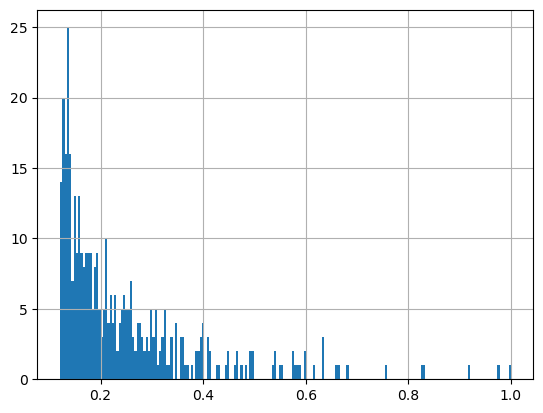

In [16]:
filtered_item_popuparity = item_popuparity[item_popuparity['popularity'] > 0.12]
filtered_item_popuparity.popularity.hist(bins=200)

filtered_item_popuparity.interactions.min(), filtered_item_popuparity.interactions.max(), filtered_item_popuparity.shape

In [17]:
item_ids = filtered_item_popuparity.item_id.unique()
item_ids.shape

(396,)

In [18]:
filtered_items        = items[items.id.isin(item_ids)]
filtered_item_genres  = item_genres[item_genres.id.isin(item_ids)]
filtered_interactions = interactions[interactions.item_id.isin(item_ids)]

In [19]:
filtered_items.shape, filtered_item_genres.shape, filtered_interactions.shape,  filtered_items.shape[0] * filtered_interactions.shape[0]

((396, 4), (396, 2), (36607, 3), 14496372)

In [20]:
database.reset()

In [21]:
items_repository.save_all(filtered_items)

In [22]:
interactions_repository.save_all(filtered_interactions)

In [23]:
ut.Picket.save('./item_genres', ut.df_to_dict(filtered_item_genres, key_column='id', value_column='genres'))

In [24]:
!cd {BASE_PATH}/recsys; python manage.py shell -c "from recsysweb.service.item_service import ItemService; ItemService().add_tags_from('../notebooks/movie-lens/item_genres')"

INFO     Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO     NumExpr defaulting to 8 threads.
INFO     Adding job tentatively -- it will be properly scheduled when the scheduler starts
INFO     Added job "update_items_stats_job" to job store "default"
INFO     Scheduler started
INFO     Item with tags: 396
INFO     Item: Toy Story (1995), Tags: ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']
INFO     Item: GoldenEye (1995), Tags: ['Action', 'Adventure', 'Thriller']
INFO     Item: American President, The (1995), Tags: ['Comedy', 'Drama', 'Romance']
INFO     Item: Casino (1995), Tags: ['Crime', 'Drama']
INFO     Item: Sense and Sensibility (1995), Tags: ['Drama', 'Romance']
INFO     Item: Ace Ventura: When Nature Calls (1995), Tags: ['Comedy']
INFO     Item: Get Shorty (1995), Tags: ['Comedy', 'Crime', 'Thriller']
INFO     Item: Leaving Las Vegas (1995), Tags: ['Drama', 'Romance']
INFO     Item: Babe (1995), Tags: ['Childr

In [25]:
!cd {BASE_PATH}; rm -rf temp
[run_job(name) for name in JOBS]

2023-05-13 16:52:50,115 :: INFO :: sentence_transformers.SentenceTransformer :: Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2023-05-13 16:52:50,292 :: INFO :: sentence_transformers.SentenceTransformer :: Use pytorch device: cuda
2023-05-13 16:52:50,292 :: INFO :: sentence_transformers.SentenceTransformer :: Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-05-13 16:52:50,561 :: INFO :: sentence_transformers.SentenceTransformer :: Use pytorch device: cuda
2023-05-13 16:52:50,561 :: INFO :: sentence_transformers.SentenceTransformer :: Load pretrained SentenceTransformer: multi-qa-mpnet-base-dot-v1
2023-05-13 16:52:51,159 :: INFO :: sentence_transformers.SentenceTransformer :: Use pytorch device: cuda
2023-05-13 16:52:51,159 :: INFO :: sentence_transformers.SentenceTransformer :: Load pretrained SentenceTransformer: all-mpnet-base-v2
2023-05-13 16:52:51,749 :: INFO :: sentence_transformers.SentenceTransformer :: Use pytorch device: cuda
2023-05-13 16:52:51,749 :: INFO 

[None, None, None, None, None, None]